In [1]:
%load_ext autoreload
%autoreload 2

from Classes_and_functions import imports

from Classes_and_functions.Dataloader import load_datasets
from Classes_and_functions.Dataloader import load_real_datasets
from Classes_and_functions.Dataloader import functions

from Classes_and_functions.Model import model_classes

from Classes_and_functions.Training import train_epochs
from Classes_and_functions.Training import functions as training_functions
from Classes_and_functions.Training import visualize_results

from Classes_and_functions.Real import functions as real_functions
from Classes_and_functions.Real import load_only_real

/home/firp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/firp/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
writer = imports.SummaryWriter()

## Dataset

In [3]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [4]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [5]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 24005
Validation: 4000
Test: 4000


In [6]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [7]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


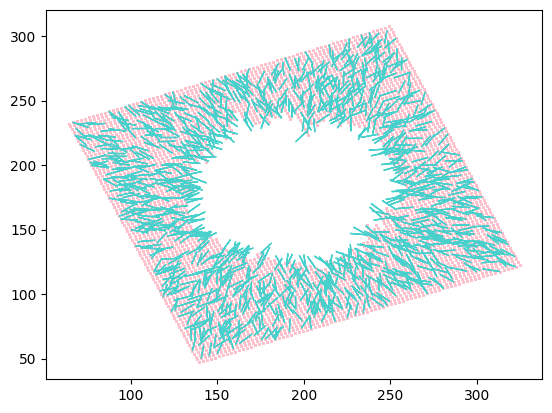

In [8]:
functions.plot_train_data(train_data)

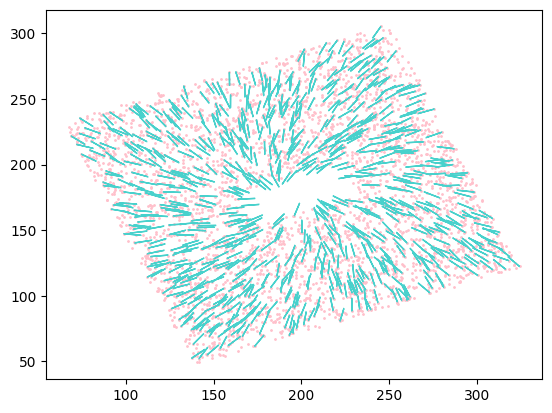

In [9]:
functions.plot_data(val_data)

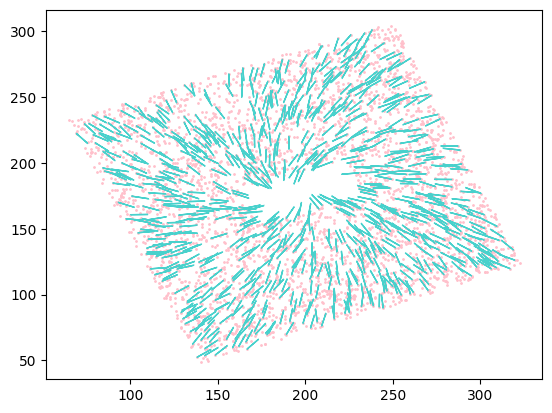

In [10]:
functions.plot_data(test_data)

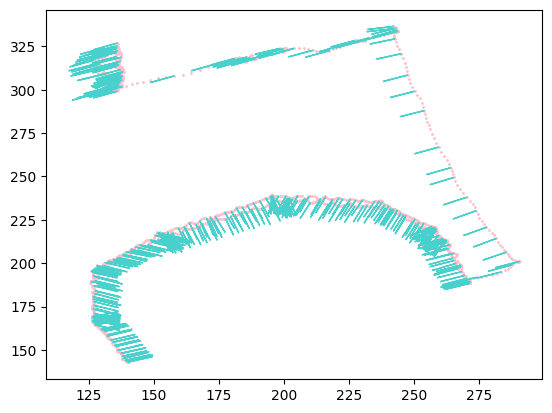

In [11]:
functions.plot_data(real_data)

In [12]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = imports.np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation before filtering: 4000


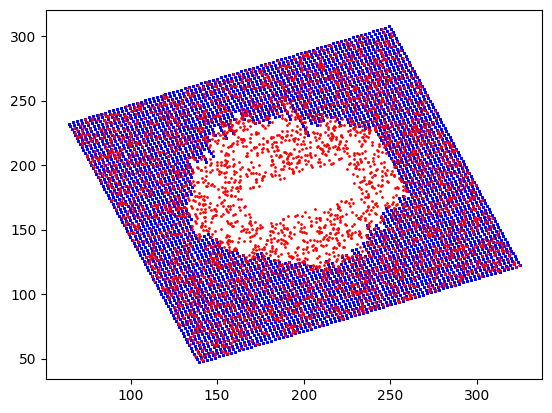

In [13]:
functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:02<00:00, 1905.33it/s]


Validation after filtering: 3253


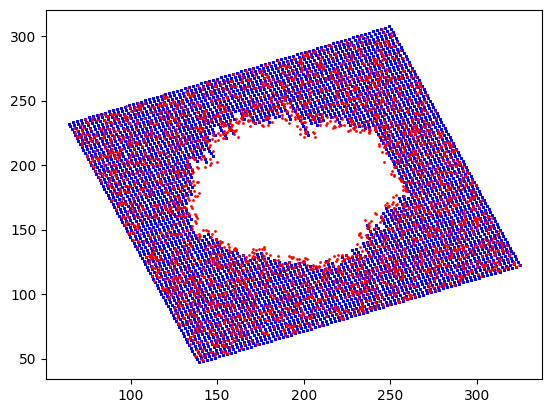

In [14]:
functions.filter_data(train_data, val_data)

functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


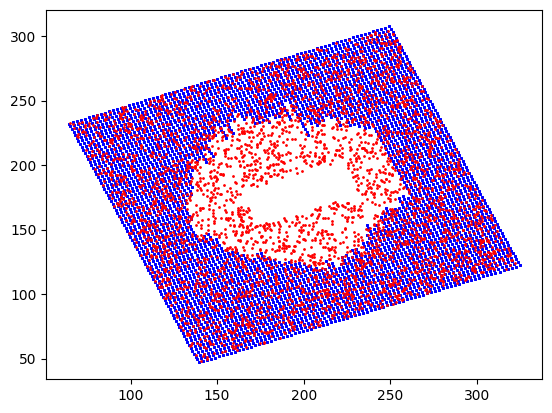

In [15]:
functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2043.93it/s]


Test after filtering: 3271


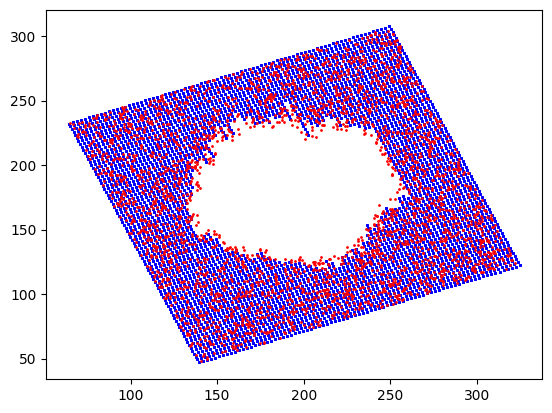

In [16]:
functions.filter_data(train_data, test_data)

functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

dist matrix tensor([0.5863, 0.5863, 0.5863, 0.5863, 0.5863])
cand tensor([276.0344, 246.0344, 231.0344, 291.0344, 261.0344])
yaw_deg 250.14171
diff yaw tensor([25.8927,  4.1073, 19.1073, 40.8927, 10.8927])
iou: 0.9607739473063088
yaw difference tensor(4.1073) deg
localization error:  0.057909023 meters


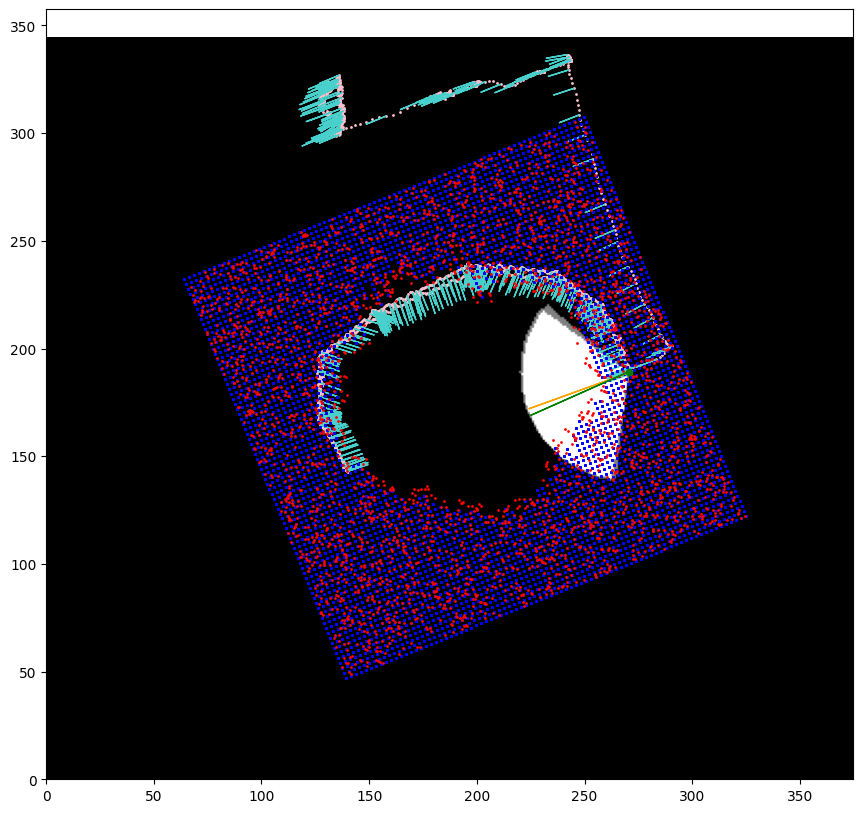

<Figure size 640x480 with 0 Axes>

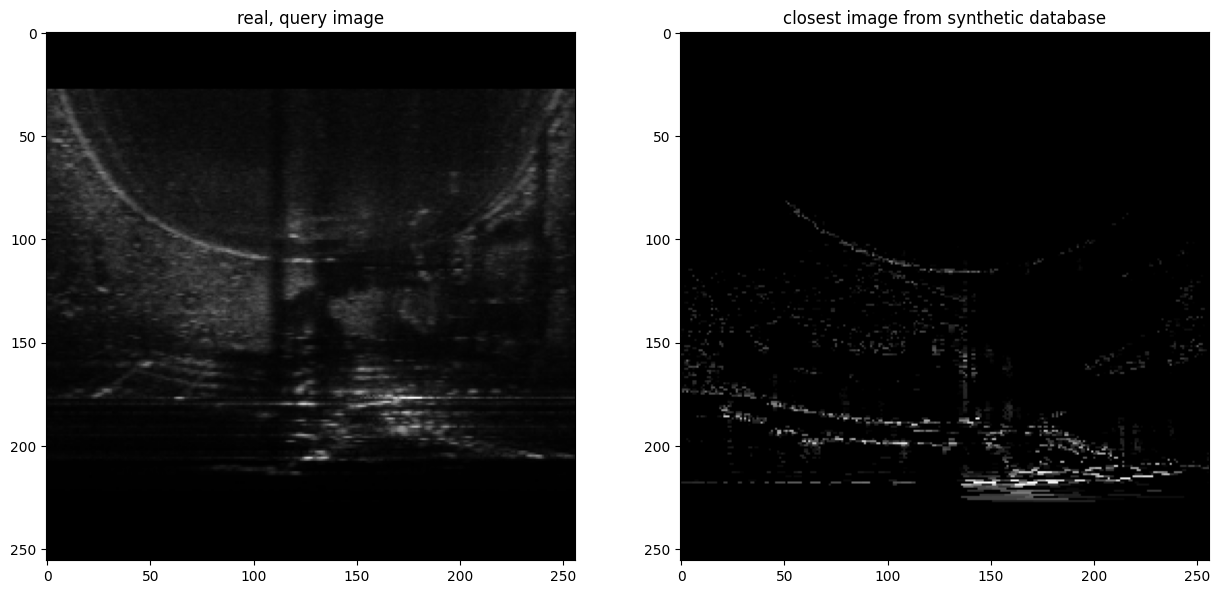

In [17]:
functions.localization(train_data, val_data, real_data)

In [18]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 24005
Validation: 3253
Test: 3271


In [19]:
val_data = functions.check_gt(train_data, val_data)

In [20]:
test_data = functions.check_gt(train_data, test_data)

In [21]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 24005
Validation: 3253
Test: 3270


In [22]:
batch = 16
train_dataloader = imports.DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [22]:
net = model_classes.Model().cuda()
net.train()

optimizer = imports.torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = imports.torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = imports.torch.nn.Dropout(0.3).cuda()

In [23]:
locacriterion = imports.torch.nn.CrossEntropyLoss().cuda()
recocriterion = imports.torch.nn.MSELoss().cuda()

## Training Pipeline

### Train epochs

In [21]:
train_epochs.train_epochs(writer, train_data, train_dataloader, net, optimizer, scheduler, drop, recocriterion, locacriterion)

 74%|████████████████████████████▉          | 1112/1501 [17:56<06:16,  1.03it/s]


KeyboardInterrupt: 

In [ ]:
training_functions.get_descriptors(train_data, val_data, net)

## Visualize Training results on Validation data

### Load the checkpoint model

In [24]:
checkpoint_path = f"correct_model_3/epoch_24.pth"
net = model_classes.Model()
model_classes.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [25]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


  0%|                                        | 64/24005 [00:00<05:48, 68.66it/s]


KeyboardInterrupt: 

In [26]:
val_data.computeDescriptors(net)

computing dataset descriptors


  3%|█▏                                       | 96/3253 [00:01<00:34, 90.63it/s]


KeyboardInterrupt: 

### Visualize query results: sonar images

In [27]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-8.5842, device='cuda:0', grad_fn=<MinBackward1>) tensor(7.1053, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-43.4675, device='cuda:0', grad_fn=<MinBackward1>) tensor(45.2597, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-23.6651, device='cuda:0', grad_fn=<MinBackward1>) tensor(25.0087, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-12.7368, device='cuda:0', grad_fn=<MinBackward1>) tensor(15.7262, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5303, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5087, device='cuda:0', grad_fn=<MaxBackward1>)


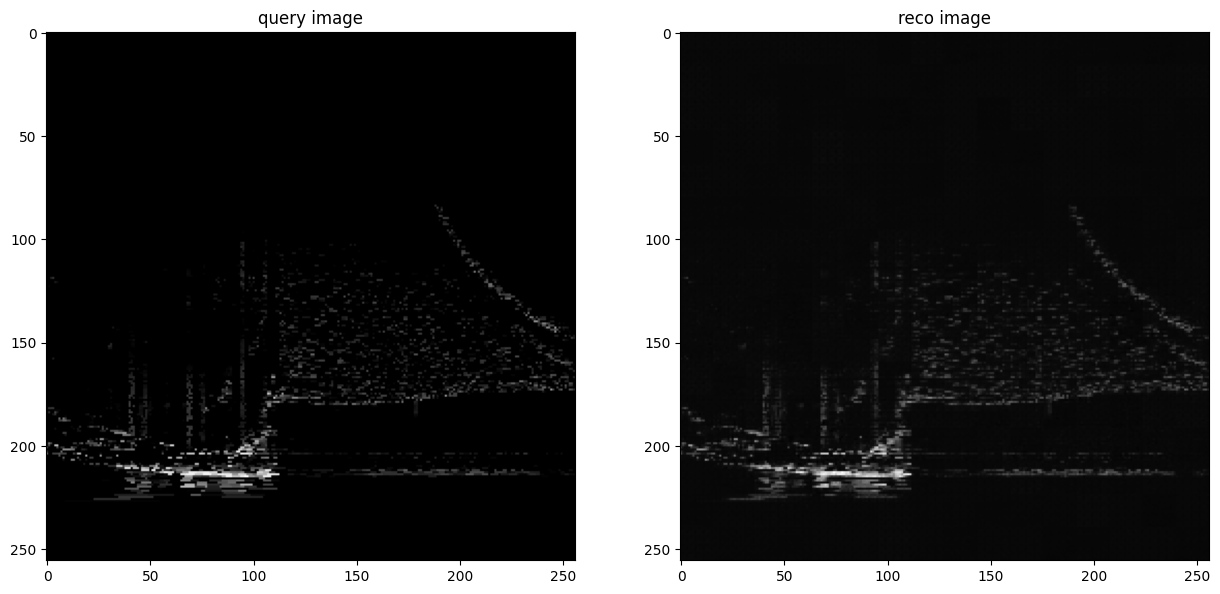

In [28]:
visualize_results.analyze_feature_robustness(train_data, net)

In [ ]:
query_idx = imports.random.randint(0, len(val_data))

loca_error, orie_error = visualize_results.process(query_idx, net, train_data, val_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in imports.tqdm(range(0, len(val_data))):
    loca_error, orie_error = visualize_results.process(query_idx, net, train_data, val_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = imports.np.array(loca_errors).mean()
avg_orie_error = imports.np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

In [ ]:
loca_errors = imports.np.array(loca_errors)
orie_errors = imports.np.array(orie_errors)

In [ ]:
loca_errors.argmax()

In [ ]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

## Visualize Training results on Test data

### Load the checkpoint model

In [ ]:
checkpoint_path = f"correct_model_3/epoch_24.pth"
net = model_classes.Model()
model_classes.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [ ]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

### Visualize query results: sonar images

In [ ]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

In [ ]:
visualize_results.analyze_feature_robustness(train_data, net)

In [ ]:
query_idx = imports.random.randint(0, len(test_data))

loca_error, orie_error = visualize_results.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in imports.tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualize_results.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

In [ ]:
loca_errors = imports.np.array(loca_errors)
orie_errors = imports.np.array(orie_errors)

In [ ]:
loca_errors.argmax()

In [ ]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

## process real images

In [ ]:
query_idx = imports.random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
real_functions.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [ ]:
real_data_train = load_only_real.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real.SonarDescriptorOnlyRealDataset(real_data_train)

In [ ]:
real_data_train.computeDescriptors(net)

In [ ]:
real_functions.visualize_real(train_data, real_data)

In [ ]:
query_idx = imports.random.randint(700, len(real_data_valid))
loca_error, orie_error = real_functions.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in imports.tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = real_functions.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = imports.np.array(loca_errors).mean()
avg_orie_error = imports.np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

In [ ]:
avg_orie_error.min()

## K-TOP

In [ ]:
K = 15
bests = database.norms.argsort()

preds = np.zeros((K, 2))
imgs = []
for i in range(K):
    _, img, minpos, _, _, _ = database.dataset[bests[i]]
    preds[i, :] = minpos[:2]
    imgs.append(img)

colors = []
for v in database.norms/database.norms.max():
    colors.append([v, 0, 0])
    
plt.scatter(train_data.poses[:train_data.synth, 0], train_data.poses[:train_data.synth, 1], c=colors, marker='o', linestyle='None', s = 1)
plt.scatter(query_gtpose[0].item(), query_gtpose[1].item(), c='green',s = 20.51, label="gt query pose")
plt.scatter(preds[:, 0], preds[:, 1], c='blue', s = 20.51, label=f"database predicted {K} closest poses")
plt.legend(loc="lower right")

plt.figure()

f, axarr = plt.subplots(K, 2, figsize=(20, 20))

axarr[0,0].set_title(f"query image")
axarr[0,1].set_title(f"retrieved image")


for i in range(K):

    axarr[i,0].imshow(query_real_image.detach().cpu().numpy()[0, :, :], cmap='gray')
    axarr[i,1].imshow(imgs[i].numpy()[0, :, :], cmap='gray')